## CNN + Transfer Learning


### Expected dataset folder structure
```
BASE_DIR/
  train/
    0/  (Healthy)
    1/  (Glaucoma)
  val/
    0/
    1/
  test/
    0/
    1/
```


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!kaggle datasets download -d sabari50312/fundus-pytorch
!unzip fundus-pytorch.zip


Streaming output truncated to the last 5000 lines.
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-16.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-160.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-163.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-164.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-165.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-168.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-17.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-170.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-173.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-175.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-177.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-179.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-18.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-180.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-181.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-182.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-185.png  
  inflating: val/0/OIA-ODIR-TEST-OFFLINE-186.png  
  inflating: val/0/OIA-ODIR-TEST-O

# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    auc as calculate_auc,
)

import matplotlib.pyplot as plt
from IPython.display import display

try:
    import seaborn as sns
except Exception:
    sns = None

tf.random.set_seed(42)
np.random.seed(42)

print('TensorFlow:', tf.__version__)


TensorFlow: 2.19.0


## 2) Configuration

Set `BASE_DIR` to your dataset root.

- On Kaggle: `BASE_DIR = "/kaggle/input/fundus-pytorch"`
- On Colab: `BASE_DIR = "/content"`
- Locally: set it to your local folder path


In [ ]:
BASE_DIR = "/content/"  # <-- change this

splits = ["train", "val", "test"]
classes = ["0", "1"]

image_size = (224, 224)
batch_size = 32

print('BASE_DIR:', BASE_DIR)


BASE_DIR: /content/


## 3) Data indexing + split

Matches your original approach:
- walk folders into a DataFrame
- drop duplicates by `image_name`
- stratified `train/val/test` split using `train_test_split`


In [ ]:
def index_dataset(base_dir: str, splits=("train", "val", "test"), classes=("0", "1")) -> pd.DataFrame:
    """
    Scans base_dir for images and returns a DataFrame with filepaths, labels, and splits.
    Expects directory structure: base_dir/{split}/{class_label}/image.jpg
    """
    rows = []
    for split in splits:
        for cls in classes:
            class_dir = os.path.join(base_dir, split, cls)
            if not os.path.isdir(class_dir):
                print('Missing folder:', class_dir)
                continue
            for file in os.listdir(class_dir):
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    rows.append(
                        {
                            "filepath": os.path.join(class_dir, file),
                            "image_name": file,
                            "label": int(cls),
                            "split": split,
                        }
                    )
    return pd.DataFrame(rows)


all_data = index_dataset(BASE_DIR, splits=splits, classes=classes)
print('Total indexed:', len(all_data))
display(all_data.head())

if len(all_data) == 0:
    raise RuntimeError('No images found. Fix BASE_DIR and re-run.')

# Drop duplicates and shuffle
all_data = all_data.drop_duplicates(subset='image_name')
all_data = all_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Re-split (stratified) to match the merged script behavior
train_df, temp_df = train_test_split(
    all_data,
    test_size=0.3,
    stratify=all_data['label'],
    random_state=42,
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42,
)

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print('Class counts (train):', pd.Series(y_train).value_counts().to_dict())


Total indexed: 17242


,filepath,image_name,label,split
0,/content/train/0/OIA-ODIR-TRAIN-2053.png,OIA-ODIR-TRAIN-2053.png,0,train
1,/content/train/0/OIA-ODIR-TRAIN-1569.png,OIA-ODIR-TRAIN-1569.png,0,train
2,/content/train/0/OIA-ODIR-TEST-ONLINE-253.png,OIA-ODIR-TEST-ONLINE-253.png,0,train
3,/content/train/0/ORIGA-212.png,ORIGA-212.png,0,train
4,/content/train/0/ORIGA-587.png,ORIGA-587.png,0,train


Train: 6034 | Val: 1293 | Test: 1294
Class counts (train): {0: 3705, 1: 2329}


## 4) `tf.data` pipeline


In [ ]:
import tensorflow as tf

def preprocess_image(filepath, label):
    """
    The 'Worker' function: Converts a raw file path into a clean tensor.
    """
    # 1. Load the raw bytes
    img = tf.io.read_file(filepath)

    # 2. Convert bytes to a 3D pixel array (RGB).
    # expand_animations=False ensures GIFs don't return a 4D tensor.
    img = tf.image.decode_image(img, channels=3, expand_animations=False)

    # 3. Resize image to the dimensions the model expects (e.g., [224, 224])
    img = tf.image.resize(img, image_size)

    # 4. Normalization: Convert [0, 255] integer pixels to [0, 1] floats.
    # This keeps gradients stable during backpropagation.
    img = tf.cast(img, tf.float32) / 255.0

    return img, tf.cast(label, tf.int32)


def make_dataset(df: pd.DataFrame, shuffle: bool) -> tf.data.Dataset:
    """
    The 'Manager' function: Orchestrates how data flows from disk to GPU.
    """
    # Create a dataset that emits (filepath, label) pairs
    ds = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label'].values))

    if shuffle:
        # Buffer size: How many items to hold in memory to pull from randomly.
        # 10,000 is a good balance between randomness and RAM usage.
        ds = ds.shuffle(buffer_size=min(len(df), 10_000), seed=42, reshuffle_each_iteration=True)

    # Map: Apply the preprocessing function to every item.
    # AUTOTUNE lets TensorFlow decide how many CPU cores to use dynamically.
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch: Group images together. Prefetch: Prepare the next batch while the GPU is busy.
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds

# Create the final dataset objects
train_dataset = make_dataset(train_df, shuffle=True)
val_dataset = make_dataset(val_df, shuffle=False)
test_dataset = make_dataset(test_df, shuffle=False)

print('Datasets created successfully.')

Datasets created successfully.


## 5) Evaluation utilities (metrics + plots + threshold search)


In [ ]:
# --- 1. THRESHOLD OPTIMIZATION ---
def find_best_threshold(y_true, y_probs, start=0.05, stop=0.96, step=0.01):
    """
    Finds the probability threshold that maximizes the F1-score.
    Useful for balancing Precision (reliability) and Recall (sensitivity).
    """
    thresholds = np.arange(start, stop, step)
    f1_scores = []
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        f1_scores.append(f1_score(y_true, y_pred, zero_division=0))

    best_idx = int(np.argmax(f1_scores))
    return float(thresholds[best_idx]), float(f1_scores[best_idx])

def plot_threshold_search(y_true, y_probs, best_thresh):
    """
    Visualizes how Precision, Recall, and F1 change as you move the decision boundary.
    The black vertical line indicates the 'optimal' point found by find_best_threshold.
    """
    thresholds = np.arange(0.01, 1.0, 0.01)
    precisions = [precision_score(y_true, (y_probs > t).astype(int), zero_division=0) for t in thresholds]
    recalls = [recall_score(y_true, (y_probs > t).astype(int), zero_division=0) for t in thresholds]
    f1s = [f1_score(y_true, (y_probs > t).astype(int), zero_division=0) for t in thresholds]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision (Low False Alarms)', color='blue', linestyle='--')
    plt.plot(thresholds, recalls, label='Recall (Finding All Cases)', color='green', linestyle='--')
    plt.plot(thresholds, f1s, label='F1 (Balanced)', color='red', lw=3)
    plt.axvline(best_thresh, color='black', label=f'Best Threshold ({best_thresh:.2f})')
    plt.xlabel('Threshold (Probability)')
    plt.ylabel('Score')
    plt.title('Threshold Search: Precision vs Recall vs F1')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# --- 2. CORE PERFORMANCE VISUALS ---

def plot_roc_curve_fixed(y_true, y_probs, title='ROC Curve'):
    """
    Plots the True Positive Rate vs False Positive Rate.
    AUC = 1.0 is a perfect model; AUC = 0.5 is a random guess.
    """
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc_val = float(calculate_auc(fpr, tpr))
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_val:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal reference line
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """
    Shows a breakdown of correct and incorrect predictions.
    Diagonal boxes (top-left, bottom-right) represent correct classifications.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    if sns is None:
        print('Seaborn is not installed; confusion matrix:\n', cm)
        return
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Healthy', 'Glaucoma'],
        yticklabels=['Healthy', 'Glaucoma'],
    )
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_training_history(history):
    """
    Plots the Accuracy and Loss curves recorded during training.
    Used to diagnose overfitting (if validation loss starts to increase).
    """
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# --- 3. MULTI-MODEL COMPARISON ---

def record_metrics(model_name, y_true, y_probs, threshold=0.5):
    """
    Compiles all scalar metrics into a dictionary for easy comparison in a table.
    """
    y_pred = (y_probs >= threshold).astype(int)
    return {
        'Model': model_name,
        'Threshold': float(threshold),
        'Accuracy': float(accuracy_score(y_true, y_pred)),
        'Precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'Recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'F1': float(f1_score(y_true, y_pred, zero_division=0)),
        'AUC': float(roc_auc_score(y_true, y_probs)),
    }

def plot_histories_overlay(history_by_model, metric='accuracy', title=None):
    """
    Overlays training curves from different models (e.g., VGG16 vs ResNet).
    Solid lines = Training; Dashed lines = Validation.
    """
    if not history_by_model:
        print('No histories recorded yet.')
        return
    plt.figure(figsize=(10, 5))
    for name, hist in history_by_model.items():
        if hist is None: continue
        y = hist.history.get(metric)
        if y: plt.plot(y, label=f'{name} train')
        yv = hist.history.get(f'val_{metric}')
        if yv: plt.plot(yv, linestyle='--', label=f'{name} val')
    plt.title(title or f'Model Comparison: {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend(ncol=2, fontsize=8)
    plt.grid(alpha=0.3)
    plt.show()

def plot_roc_overlay(test_probs_by_model, y_true, title='ROC Overlay (Test Comparison)'):
    """
    Overlays ROC curves for multiple models to visualize which one is the top performer.
    """
    if not test_probs_by_model:
        print('No test probabilities recorded yet.')
        return
    plt.figure(figsize=(8, 6))
    for name, probs in test_probs_by_model.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc_val = float(calculate_auc(fpr, tpr))
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={roc_auc_val:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)
    plt.show()

## 6) Models

- CNN



In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras  # Ensure keras is imported for keras.layers and keras.metrics

# =========================================================
# Function: build_cnn_model
# Purpose: Builds a custom CNN from scratch for binary classification
# Parameters:
#   dropout_rate - fraction of neurons to drop for regularization
# =========================================================
def build_cnn_model(dropout_rate=0.5):
    model = keras.models.Sequential(
        [
            # 1st convolutional layer: 200 filters, 3x3 kernel, ReLU activation
            keras.layers.Conv2D(200, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),

            # 2nd convolutional layer: 150 filters, 3x3 kernel
            keras.layers.Conv2D(150, kernel_size=(3, 3), activation='relu'),

            # Max pooling to reduce spatial dimensions, 4x4 pool size
            keras.layers.MaxPool2D(4, 4),

            # 3rd convolutional layer
            keras.layers.Conv2D(120, kernel_size=(3, 3), activation='relu'),

            # 4th convolutional layer
            keras.layers.Conv2D(80, kernel_size=(3, 3), activation='relu'),

            # 5th convolutional layer
            keras.layers.Conv2D(50, kernel_size=(3, 3), activation='relu'),

            # Another max pooling layer
            keras.layers.MaxPool2D(4, 4),

            # Flatten feature maps to a vector for dense layers
            keras.layers.Flatten(),

            # Fully connected layers
            keras.layers.Dense(120, activation='relu'),
            keras.layers.Dense(100, activation='relu'),
            keras.layers.Dense(50, activation='relu'),

            # Dropout for regularization
            keras.layers.Dropout(rate=dropout_rate),

            # Output layer: 1 neuron with sigmoid activation for binary classification
            keras.layers.Dense(1, activation='sigmoid'),
        ]
    )

    # Compile the model
    # Metrics include accuracy, precision, recall, and AUC
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
        ],
    )
    return model


# =========================================================
# Function: build_tl_model
# Purpose: Builds a transfer learning model using a pretrained backbone
# Parameters:
#   app_fn      - Keras application function (e.g., tf.keras.applications.ResNet50)
#   model_name  - Name for the model
#   lr          - Learning rate for Adam optimizer
#   dropout_rate - Dropout rate after global pooling
# =========================================================
def build_tl_model(app_fn, model_name, lr=1e-4, dropout_rate=0.5):
    try:
        # Load pretrained backbone
        base_model = app_fn(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    except Exception as e:
        # Fallback if ImageNet weights cannot be loaded
        print(f"[WARN] Could not load ImageNet weights for {model_name}. Falling back to weights=None.\nReason: {e}")
        base_model = app_fn(input_shape=(224, 224, 3), include_top=False, weights=None)

    # Allow fine-tuning of the base model
    base_model.trainable = True

    # Global average pooling reduces each feature map to a single number
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Dropout layer for regularization
    x = keras.layers.Dropout(dropout_rate)(x)

    # Final sigmoid output for binary classification
    out = Dense(1, activation='sigmoid', name='Final')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=out, name=model_name)

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
        ],
    )
    return model


# =========================================================
# Function: get_callbacks
# Purpose: Returns common callbacks for training
# Parameters:
#   patience_es - patience for early stopping (number of epochs with no improvement)
#   patience_rlr - patience for ReduceLROnPlateau
# =========================================================
def get_callbacks(patience_es=3, patience_rlr=2):
    return [
        # Stops training if val_loss doesn't improve for 'patience_es' epochs
        EarlyStopping(
            monitor='val_loss',
            patience=patience_es,
            restore_best_weights=True,
            verbose=1,
        ),
        # Reduces learning rate by factor if val_loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=patience_rlr,
            min_lr=1e-7,
            verbose=1,
        ),
    ]


# =========================================================
# Function: predict_probs
# Purpose: Returns predicted probabilities from a dataset
# Parameters:
#   model - trained keras model
#   ds    - dataset (tf.data.Dataset or numpy arrays)
# =========================================================
def predict_probs(model, ds):
    # Flatten predictions to 1D array
    return model.predict(ds, verbose=1).reshape(-1)


## 7) Train + evaluate CNN (baseline)

This notebook now trains **only the baseline CNN** (`CNN_plain`) with a fixed threshold of **0.5**.


In [ ]:
# Stores results for *all* later sections (CNN + transfer learning)
model_performance_records = []
history_by_model = {}
test_probs_by_model = {}

=== CNN_plain ===
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.6150 - auc: 0.5600 - loss: 0.6693 - precision: 0.5236 - recall: 0.1122 - val_accuracy: 0.6937 - val_auc: 0.7116 - val_loss: 0.6028 - val_precision: 0.7395 - val_recall: 0.3186
Epoch 2/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 153s 719ms/step - accuracy: 0.7017 - auc: 0.6804 - loss: 0.6094 - precision: 0.7060 - recall: 0.3869 - val_accuracy: 0.7224 - val_auc: 0.7211 - val_loss: 0.5746 - val_precision: 0.8125 - val_recall: 0.3647
Epoch 3/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 135s 714ms/step - accuracy: 0.7157 - auc: 0.7031 - loss: 0.5823 - precision: 0.7366 - recall: 0.4117 - val_accuracy: 0.7510 - val_auc: 0.7627 - val_loss: 0.5377 - val_precision: 0.8266 - val_recall: 0.4489
Epoch 4/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 135s 714ms/step - accuracy: 0.7270 - auc: 0.7196 - loss: 0.5730 - precision: 0.7744 - recall: 0.4218 - val_accuracy: 0.7556 - val_auc: 0.7746 - val_loss: 0.5335 - val_precision: 0.7453 - val_recall: 0.5571
Epoch 5/15
189/189 ━━━━━━━━━━━

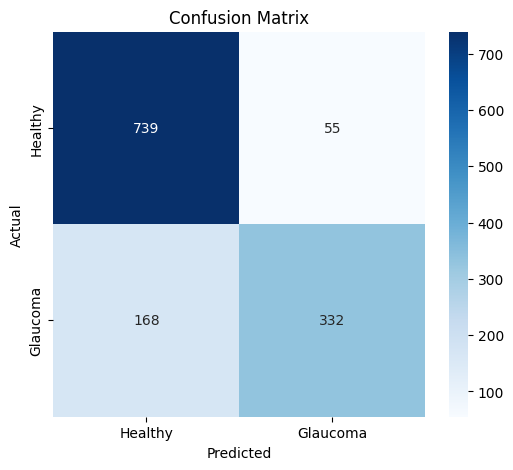

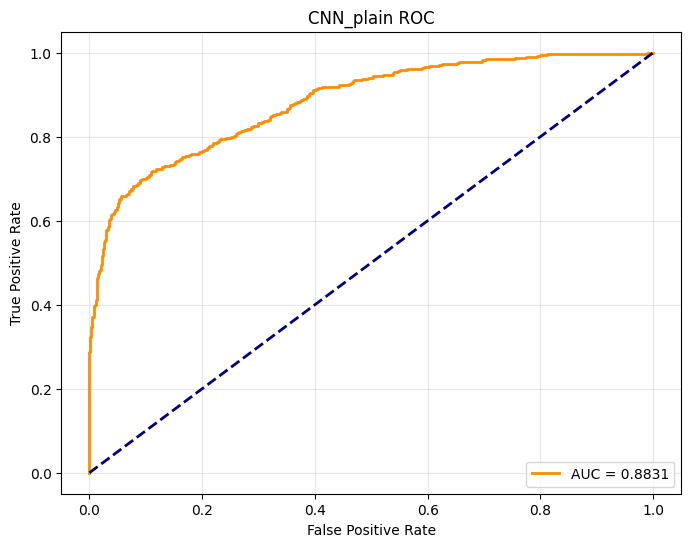

,Model,Threshold,Accuracy,Precision,Recall,F1,AUC
0,CNN_plain,0.5,0.8277,0.8579,0.664,0.7486,0.8831


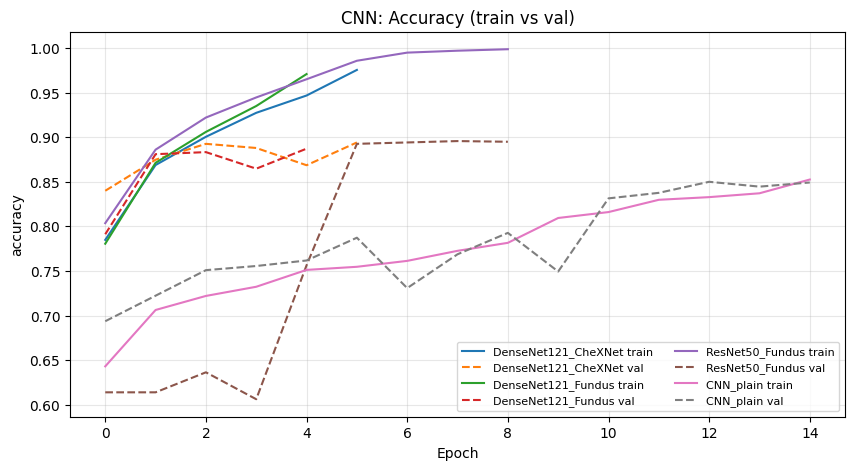

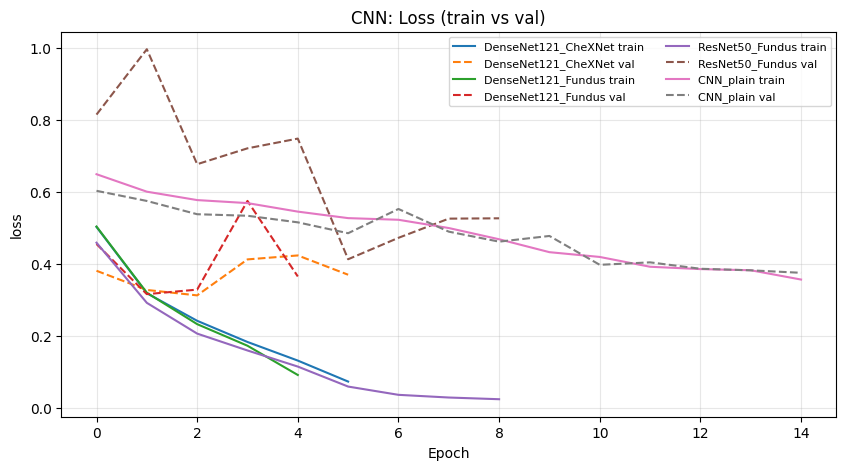

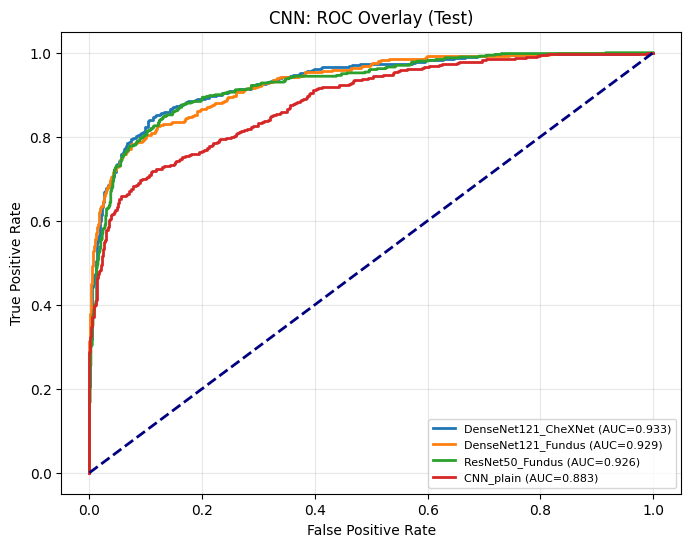

In [ ]:
# =========================================================
# Training a CNN from scratch
# =========================================================

# Number of training epochs
EPOCHS_CNN = 15

# Callbacks: EarlyStopping stops training if validation loss doesn't improve
cnn_callbacks = [
    EarlyStopping(
        monitor='val_loss',      # Monitor validation loss
        patience=7,              # Wait 7 epochs before stopping
        restore_best_weights=True, # Roll back to the best weights
        verbose=1
    )
]

print('=== CNN_plain ===')

# Build the CNN model with a dropout rate of 0.5
cnn_plain = build_cnn_model(dropout_rate=0.5)

# Train the model
history_plain = cnn_plain.fit(
    train_dataset,              # Training data (tf.data.Dataset)
    epochs=EPOCHS_CNN,          # Number of epochs
    validation_data=val_dataset, # Validation dataset for monitoring
    callbacks=cnn_callbacks,     # Early stopping callbacks
    verbose=1                   # Show progress per epoch
)

# Store training history for later visualization
history_by_model['CNN_plain'] = history_plain

# =========================================================
# Generate predictions for test data
# =========================================================

# Predict probabilities (continuous values between 0 and 1)
probs_plain = predict_probs(cnn_plain, test_dataset)
test_probs_by_model['CNN_plain'] = probs_plain

# Evaluate metrics and store in a list
# record_metrics likely calculates accuracy, precision, recall, F1-score, AUC, etc.
model_performance_records.append(
    record_metrics('CNN_plain', y_test, probs_plain, threshold=0.5)
)

# Convert probabilities to binary predictions using threshold=0.5
pred_plain = (probs_plain >= 0.5).astype(int)

# Print detailed classification report
# target_names=['Healthy', 'Glaucoma'] maps 0->Healthy, 1->Glaucoma
# zero_division=0 avoids division errors if a class has no predicted samples
print(classification_report(y_test, pred_plain, target_names=['Healthy', 'Glaucoma'], zero_division=0))

# Plot confusion matrix
plot_confusion_matrix(y_test, pred_plain)

# Plot ROC curve
plot_roc_curve_fixed(y_test, probs_plain, title='CNN_plain ROC')

# =========================================================
# Visualize training history and compare models
# =========================================================

# Display performance metrics as a DataFrame (rounded to 4 decimals)
display(pd.DataFrame(model_performance_records).round(4))

# Overlay training vs validation accuracy for the CNN
plot_histories_overlay(history_by_model, metric='accuracy', title='CNN: Accuracy (train vs val)')

# Overlay training vs validation loss
plot_histories_overlay(history_by_model, metric='loss', title='CNN: Loss (train vs val)')

# Overlay ROC curves for different models on the test set
plot_roc_overlay(test_probs_by_model, y_test, title='CNN: ROC Overlay (Test)')


## 8) specialized weights models

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# =========================================================
# 1. Specialized Transfer Learning Model Builder
# =========================================================
def build_tl_model(app_fn, model_name, weights_path=None):
    """
    Builds a transfer learning model with optional custom pretrained weights.

    Parameters:
        app_fn      : Keras application function (e.g., tf.keras.applications.DenseNet121)
        model_name  : Name of the model (used for logging and weights handling)
        weights_path: Optional path to custom pretrained weights

    Returns:
        model       : Compiled Keras model ready for training
    """

    # Load the backbone pretrained on ImageNet
    base_model = app_fn(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    # --- Specialized weight handling ---
    if model_name == 'DenseNet121_CheXNet' and weights_path and os.path.exists(weights_path):
        # CheXNet weights are multi-label (14 outputs), load them first
        print(f"Applying CheXNet weights to {model_name}...")
        x = GlobalAveragePooling2D()(base_model.output)
        temp_out = Dense(14, activation='sigmoid')(x)
        temp_model = Model(inputs=base_model.input, outputs=temp_out)
        temp_model.load_weights(weights_path)
    elif weights_path and os.path.exists(weights_path):
        # For other models, load custom weights as much as possible
        print(f"Loading custom weights: {weights_path}")
        base_model.load_weights(weights_path, by_name=True, skip_mismatch=True)

    # Make the backbone trainable for fine-tuning
    base_model.trainable = True

    # Global average pooling converts feature maps to a vector
    x = base_model.output

    # --- Regularization to combat overfitting ---
    x = Dropout(0.6)(x)  # High dropout for small medical dataset
    predictions = Dense(
        1,
        activation='sigmoid',
        name='Glaucoma_Output',
        kernel_regularizer=regularizers.l2(0.01)  # Penalize large weights
    )(x)

    # Build and compile the final model
    model = Model(inputs=base_model.input, outputs=predictions, name=model_name)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# =========================================================
# 2. Callbacks
# =========================================================
def get_callbacks():
    """
    Returns a standard set of callbacks for early stopping and learning rate reduction.

    EarlyStopping: Stops training if val_loss does not improve for 3 epochs
    ReduceLROnPlateau: Reduces learning rate by factor 0.2 if val_loss plateaus
    """
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-7,
            verbose=1
        )
    ]

# =========================================================
# 3. Transfer Learning Training Loop
# =========================================================

# List of models with (name, Keras function, optional weights)
TRANSFER_MODELS = [
    ('DenseNet121_CheXNet', tf.keras.applications.DenseNet121, 'chexnet_weights.h5'),
    ('DenseNet121_Fundus', tf.keras.applications.DenseNet121, 'fundus_weights.h5'),
    ('ResNet50_Fundus', tf.keras.applications.ResNet50, 'resnet_fundus.h5'),
]

# Loop through each model and train/evaluate
for name, app_fn, w_path in TRANSFER_MODELS:
    print(f"\n--- Training {name} ---")

    # Build model
    model = build_tl_model(app_fn, name, weights_path=w_path)

    performance_records = []  # Will store metrics for this model

    # Train model
    history = model.fit(
        train_dataset,             # Training data (tf.data.Dataset)
        validation_data=val_dataset,
        epochs=10,                 # Max epochs; EarlyStopping may stop earlier
        callbacks=get_callbacks(), # Callbacks for stopping and LR scheduling
        verbose=1
    )

    # Save training history
    history_by_model[name] = history

    # Predict probabilities on test set
    probs = model.predict(test_dataset).reshape(-1)
    test_probs_by_model[name] = probs

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test, probs)
    performance_records.append({'Model': name, 'AUC': auc(fpr, tpr)})

    # Optionally, you can also record other metrics like accuracy, precision, recall
    # model_performance_records.append(record_metrics(name, y_test, probs, threshold=0.5))

    # Clear TensorFlow session to free GPU memory before next model
    tf.keras.backend.clear_session()



--- Training DenseNet121_CheXNet ---
Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.7259 - auc: 0.7903 - loss: 0.6044 - val_accuracy: 0.8399 - val_auc: 0.9191 - val_loss: 0.3805 - learning_rate: 1.0000e-04
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 63s 331ms/step - accuracy: 0.8742 - auc: 0.9388 - loss: 0.3199 - val_accuracy: 0.8747 - val_auc: 0.9417 - val_loss: 0.3271 - learning_rate: 1.0000e-04
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 82s 334ms/step - accuracy: 0.9018 - auc: 0.9665 - loss: 0.2375 - val_accuracy: 0.8925 - val_auc: 0.9523 - val_loss: 0.3120 - learning_rate: 1.0000e-04
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 83s 340ms/step - accuracy: 0.9364 - auc: 0.9832 - loss: 0.1668 - val_accuracy: 0.8879 - val_auc: 0.9344 - val_loss: 0.4121 - learning_rate: 1.0000e-04
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9487 - auc: 0.9913 - loss: 0.1240
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
189/189 ━━━━━━━━━━━━━


Evaluation for DenseNet121_CheXNet
Accuracy: 0.8694
AUC: 0.9325
              precision    recall  f1-score   support

     Healthy       0.89      0.90      0.89       794
    Glaucoma       0.84      0.82      0.83       500

    accuracy                           0.87      1294
   macro avg       0.86      0.86      0.86      1294
weighted avg       0.87      0.87      0.87      1294



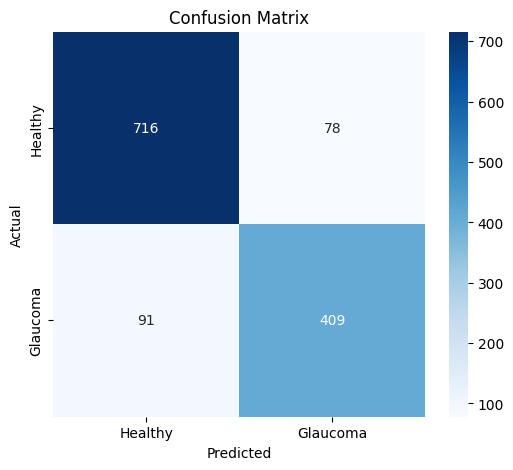

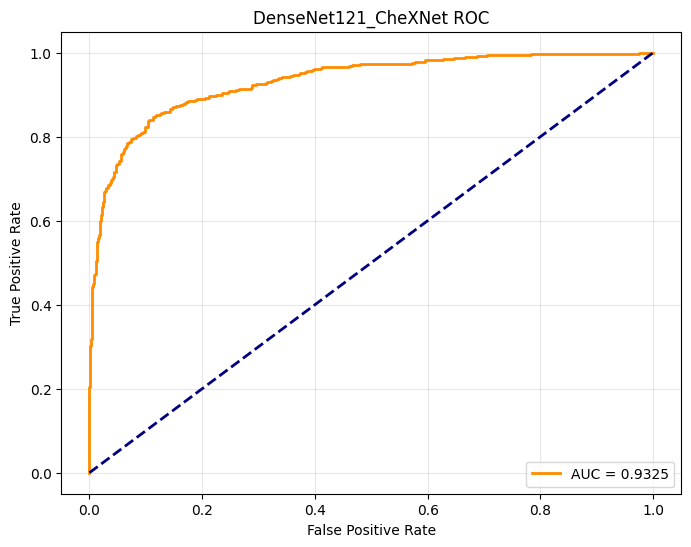


Evaluation for DenseNet121_Fundus
Accuracy: 0.8609
AUC: 0.9291
              precision    recall  f1-score   support

     Healthy       0.88      0.90      0.89       794
    Glaucoma       0.84      0.80      0.82       500

    accuracy                           0.86      1294
   macro avg       0.86      0.85      0.85      1294
weighted avg       0.86      0.86      0.86      1294



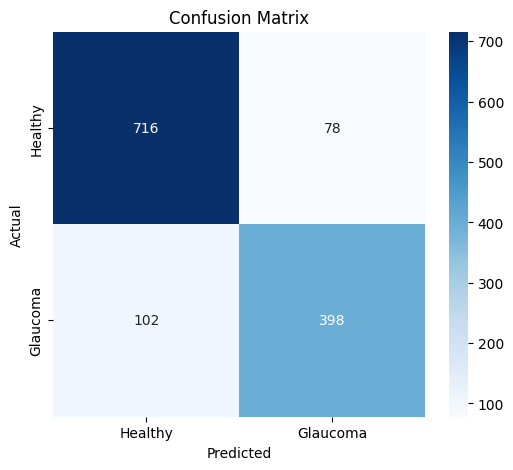

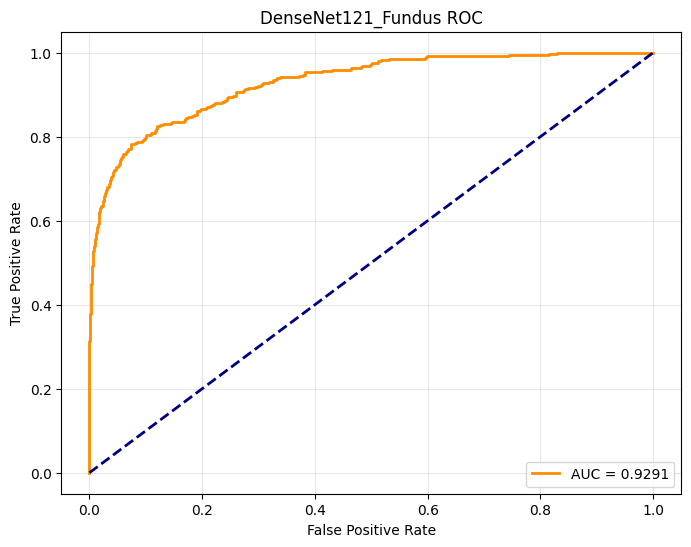


Evaluation for ResNet50_Fundus
Accuracy: 0.8640
AUC: 0.9259
              precision    recall  f1-score   support

     Healthy       0.88      0.90      0.89       794
    Glaucoma       0.84      0.80      0.82       500

    accuracy                           0.86      1294
   macro avg       0.86      0.85      0.86      1294
weighted avg       0.86      0.86      0.86      1294



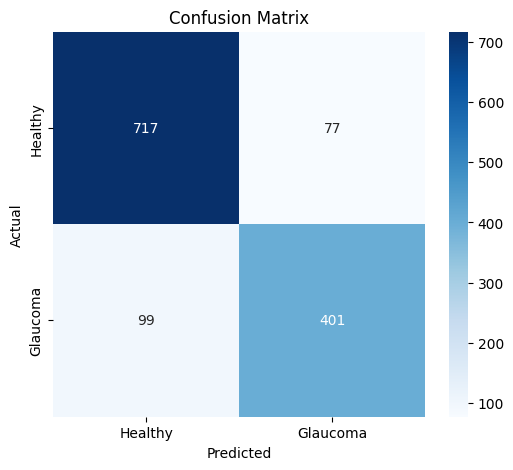

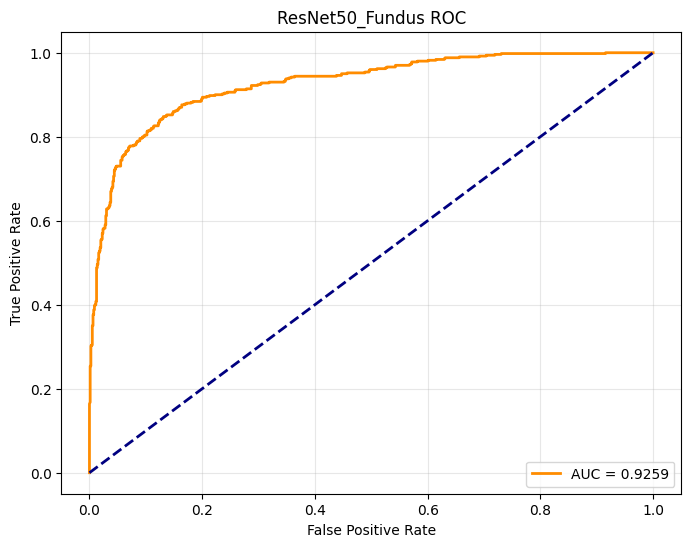


Evaluation for CNN_plain
Accuracy: 0.8277
AUC: 0.8831
              precision    recall  f1-score   support

     Healthy       0.81      0.93      0.87       794
    Glaucoma       0.86      0.66      0.75       500

    accuracy                           0.83      1294
   macro avg       0.84      0.80      0.81      1294
weighted avg       0.83      0.83      0.82      1294



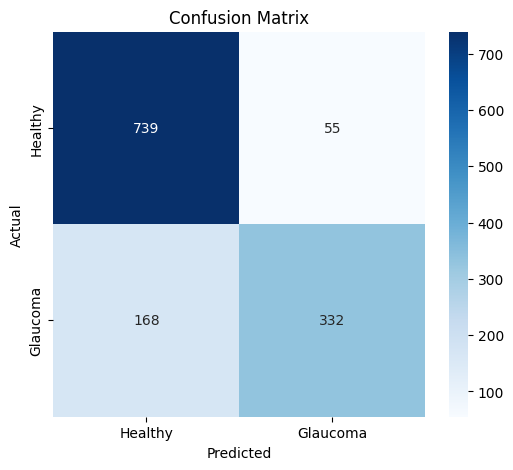

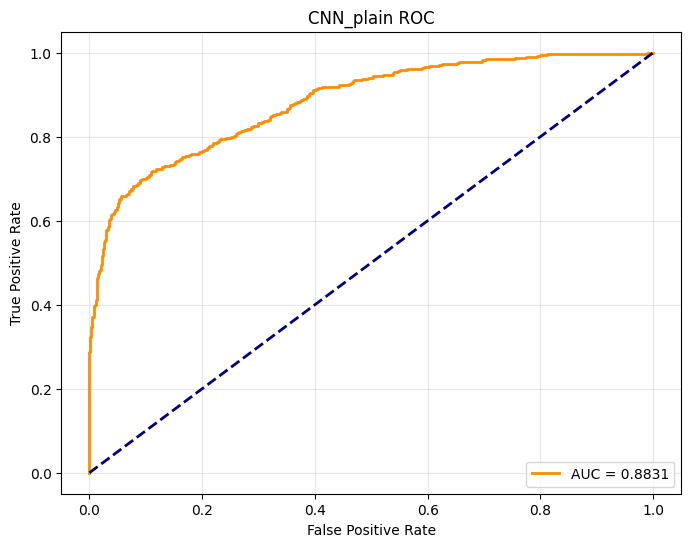

,Model,Accuracy,AUC
0,DenseNet121_CheXNet,0.8694,0.9325
1,DenseNet121_Fundus,0.8609,0.9291
2,ResNet50_Fundus,0.8640,0.9259
3,CNN_plain,0.8277,0.8831


In [ ]:
# =========================================
# EVALUATION CELL (AFTER TRAINING IS DONE)
# =========================================

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report
)

evaluation_records = []

for model_name, probs in test_probs_by_model.items():
    print("\n" + "=" * 40)
    print(f"Evaluation for {model_name}")
    print("=" * 40)

    # --- Predictions ---
    preds = (probs >= 0.5).astype(int)

    # --- Metrics ---
    acc = accuracy_score(y_test, preds)
    auc_score = roc_auc_score(y_test, probs)

    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc_score:.4f}")

    # --- Classification Report ---
    print(classification_report(
        y_test,
        preds,
        target_names=['Healthy', 'Glaucoma'],
        zero_division=0
    ))

    # --- Confusion Matrix ---
    plot_confusion_matrix(y_test, preds)

    # --- ROC Curve ---
    plot_roc_curve_fixed(y_test, probs, title=f'{model_name} ROC')

    # --- Store Results ---
    evaluation_records.append({
        'Model': model_name,
        'Accuracy': acc,
        'AUC': auc_score
    })

# --- Final Summary Table ---
evaluation_df = pd.DataFrame(evaluation_records).round(4)
display(evaluation_df)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_classification_metrics(y_true, probs, threshold=0.5):
    preds = (probs >= threshold).astype(int)
    return {
        'Accuracy': accuracy_score(y_true, preds),
        'Precision': precision_score(y_true, preds, zero_division=0),
        'Recall': recall_score(y_true, preds, zero_division=0),
        'F1-score': f1_score(y_true, preds, zero_division=0),
    }

# Build comparison table
metrics_records = []

for model_name, probs in test_probs_by_model.items():
    metrics = compute_classification_metrics(y_test, probs, threshold=0.5)
    metrics['Model'] = model_name
    metrics_records.append(metrics)

metrics_df = pd.DataFrame(metrics_records).set_index('Model').round(4)
metrics_df


,Accuracy,Precision,Recall,F1-score
Model,,,,
DenseNet121_CheXNet,0.8694,0.8398,0.818,0.8288
DenseNet121_Fundus,0.8609,0.8361,0.796,0.8156
ResNet50_Fundus,0.8640,0.8389,0.802,0.8200
CNN_plain,0.8277,0.8579,0.664,0.7486


<Figure size 1200x600 with 0 Axes>

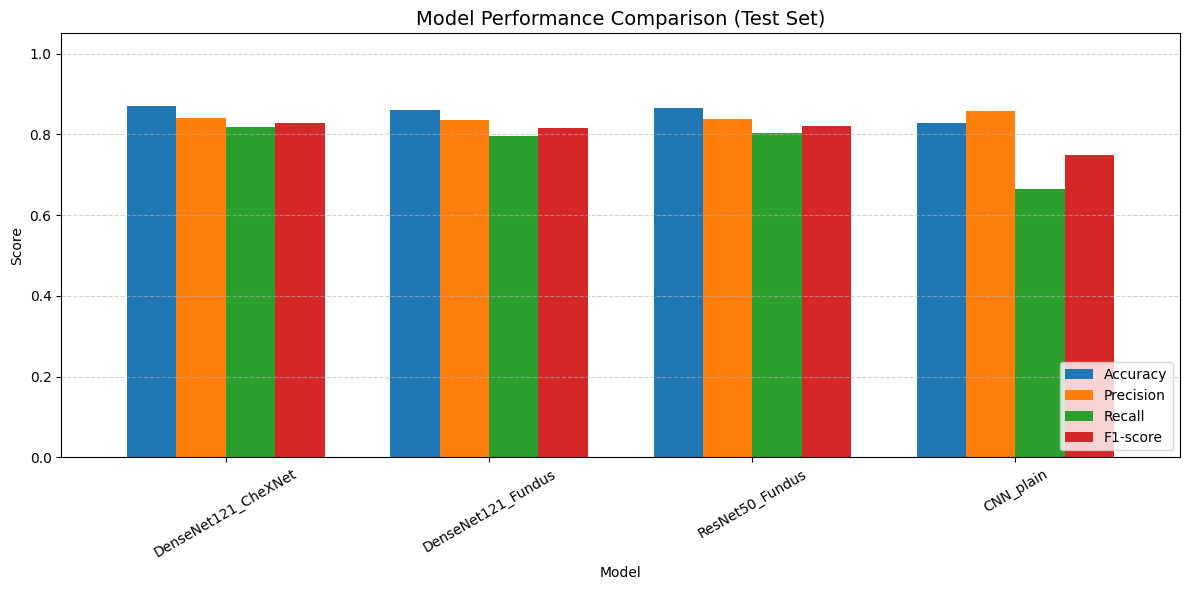

In [ ]:
plt.figure(figsize=(12, 6))

metrics_df.plot(
    kind='bar',
    width=0.75,
    figsize=(12, 6)
)

plt.title('Model Performance Comparison (Test Set)', fontsize=14)
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
